<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](./data/mountain/art1131.jpg)|![](./data/forest/cdmc317.jpg)|

The problem is realively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several differnet possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D()
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional additional full connected layers to our model. We we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = res.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(res.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

## Load in Data

![skimage-logo](https://scikit-image.org/_static/img/logo.png)

Check out out [`skimage`](https://scikit-image.org/) for useful functions related to processing the images. In particular checkout the documentation for `skimage.io.imread_collection` and `skimage.transform.resize`.

In [1]:
!pip install --upgrade scikit-image
!pip install --upgrade numpy

     |████████████████████████████████| 26.5MB 278kB/s eta 0:00:01
  Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 20.2MB 3.2MB/s eta 0:00:01
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
You should consider upgrading via the 'pip install --upgrade pip' command.


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os, re

from skimage import data, io, filters
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from keras import backend as K 

from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

In [3]:
resnet = ResNet50(weights='imagenet', include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 2s 0us/step


In [4]:
for layer in resnet.layers:
    layer.trainable = False

In [5]:
mountain_dir = "./data/mountain/"
forest_dir = "./data/forest/"

mountain_files = [image.load_img(mountain_dir+f) for f in os.listdir(mountain_dir) if re.search('.jpg', f)]
forest_files = [image.load_img(forest_dir+f) for f in os.listdir(forest_dir) if re.search('.jpg',f)]


In [6]:
mountain_array = [image.img_to_array(mountain_files[ii])for ii in range(len(mountain_files))]
forest_array = [image.img_to_array(forest_files[ii])for ii in range(len(forest_files))]
mountain_label = [[1] for _ in range(len(mountain_array))]
forest_label = [[0] for _ in range(len(forest_files))]

In [7]:
df = np.asarray(mountain_array+forest_array)
label = np.asarray(mountain_label+forest_label)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size = 0.2, stratify = label)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((561, 256, 256, 3), (561, 1), (141, 256, 256, 3), (141, 1))

In [10]:
X_train, X_test = X_train / 255.0, X_test / 255.0 #normalize pixel value

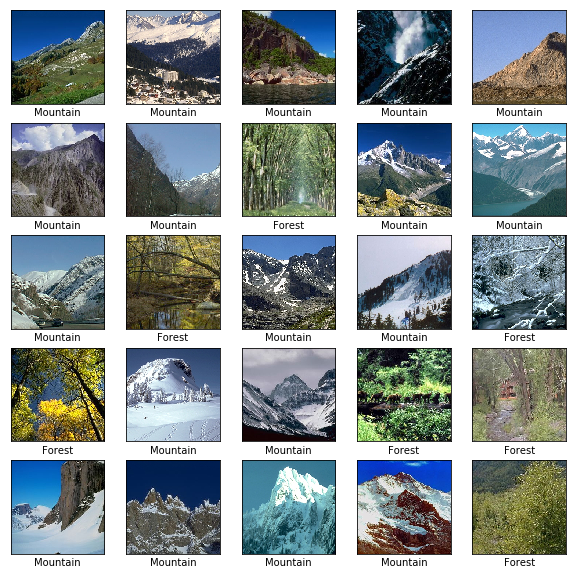

In [11]:
class_names = {1:'Mountain', 0:'Forest'}

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## Instatiate Model

In [12]:
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Fit Model

In [14]:
model.fit(X_train, 
          y_train, 
          epochs=10, 
          validation_data=(X_test, y_test))

Train on 561 samples, validate on 141 samples
Epoch 1/10
561/561 [==============================] - 145s 259ms/sample - loss: 1.2634 - acc: 0.8645 - val_loss: 1.0239 - val_acc: 0.4681
Epoch 2/10
561/561 [==============================] - 138s 245ms/sample - loss: 0.4812 - acc: 0.8984 - val_loss: 0.9088 - val_acc: 0.4681
Epoch 3/10
561/561 [==============================] - 138s 246ms/sample - loss: 0.0328 - acc: 0.9875 - val_loss: 1.4657 - val_acc: 0.4681
Epoch 4/10
561/561 [==============================] - 136s 242ms/sample - loss: 0.0365 - acc: 0.9857 - val_loss: 0.6846 - val_acc: 0.5106
Epoch 5/10
561/561 [==============================] - 137s 245ms/sample - loss: 0.2307 - acc: 0.9465 - val_loss: 0.8952 - val_acc: 0.4752
Epoch 6/10
561/561 [==============================] - 138s 246ms/sample - loss: 0.0232 - acc: 0.9875 - val_loss: 0.6921 - val_acc: 0.5319
Epoch 7/10
561/561 [==============================] - 138s 246ms/sample - loss: 0.1354 - acc: 0.9679 - val_loss: 0.8716 - val_

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

141/141 - 26s - loss: 0.6584 - acc: 0.5745


# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

In [16]:
X_train.shape[0]

561

In [25]:
# Setup Architecture

custom_model = Sequential()

custom_model.add(Conv2D(32, (2,2), activation='relu', input_shape=(256,256,3)))
custom_model.add(AveragePooling2D((2,2)))

custom_model.add(Conv2D(64, (2,2), activation='relu'))
custom_model.add(Dropout(0.2))
custom_model.add(AveragePooling2D((2,2)))

custom_model.add(Conv2D(64, (2,2), activation='relu'))
custom_model.add(MaxPooling2D((2,2)))

custom_model.add(Flatten())
custom_model.add(Dense(64, activation='relu'))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(1, activation='sigmoid'))

custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
average_pooling2d (AveragePo (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 126, 126, 64)      8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 62, 62, 64)        16448     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 64)       

In [26]:
# Compile Model
custom_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
# Fit Model
custom_model.fit(X_train, 
          y_train, 
          epochs=10, 
          validation_data=(X_test, y_test))

Train on 561 samples, validate on 141 samples
Epoch 1/10
561/561 [==============================] - 25s 45ms/sample - loss: 1.4571 - acc: 0.6417 - val_loss: 0.4437 - val_acc: 0.8298
Epoch 2/10
561/561 [==============================] - 24s 42ms/sample - loss: 0.4944 - acc: 0.7665 - val_loss: 0.4046 - val_acc: 0.8582
Epoch 3/10
561/561 [==============================] - 24s 42ms/sample - loss: 0.3490 - acc: 0.8449 - val_loss: 0.2385 - val_acc: 0.8936
Epoch 4/10
561/561 [==============================] - 24s 42ms/sample - loss: 0.4469 - acc: 0.8271 - val_loss: 0.2440 - val_acc: 0.9007
Epoch 5/10
561/561 [==============================] - 24s 42ms/sample - loss: 0.2245 - acc: 0.9216 - val_loss: 0.3044 - val_acc: 0.8794
Epoch 6/10
561/561 [==============================] - 24s 42ms/sample - loss: 0.3469 - acc: 0.8681 - val_loss: 0.2391 - val_acc: 0.9078
Epoch 7/10
561/561 [==============================] - 25s 45ms/sample - loss: 0.2546 - acc: 0.9162 - val_loss: 0.2116 - val_acc: 0.8936
Ep

In [28]:
test_loss_custom, test_acc_custom = custom_model.evaluate(X_test, y_test, verbose=2)

141/141 - 1s - loss: 0.1840 - acc: 0.9504


In [62]:
# !wget https://cdn.mos.cms.futurecdn.net/ntFmJUZ8tw3ULD3tkBaAtf-650-80.jpg #random internet photo
# !wget https://www.nps.gov/piro/learn/nature/images/DeepForest_1.JPG

--2020-02-21 21:40:12--  https://www.nps.gov/piro/learn/nature/images/DeepForest_1.JPG
Resolving www.nps.gov (www.nps.gov)... 23.13.171.207, 2600:1408:8400:5a3::20ce, 2600:1408:8400:598::20ce
Connecting to www.nps.gov (www.nps.gov)|23.13.171.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘DeepForest_1.JPG’

DeepForest_1.JPG        [  <=>               ]   2.07M  6.44MB/s    in 0.3s    

2020-02-21 21:40:13 (6.44 MB/s) - ‘DeepForest_1.JPG’ saved [2173277]



In [66]:
img = Image.open('ntFmJUZ8tw3ULD3tkBaAtf-650-80.jpg')
img = [img.resize((256, 256), Image.ANTIALIAS)]

test_image = np.asarray([image.img_to_array(img[0])])

prediction = custom_model.predict(test_image)
print(f'The model predicts the image is a {class_names[int(prediction[0][0])]}')

The model predicts the image is a Mountain


In [68]:
img_f = Image.open('DeepForest_1.JPG')
img_f = [img_f.resize((256, 256), Image.ANTIALIAS)]

test_image_2 = np.asarray([image.img_to_array(img_f[0])])

prediction_2 = custom_model.predict(test_image_2)
print(f'The model predicts the image is a {class_names[int(prediction_2[0][0])]}')

The model predicts the image is a Mountain


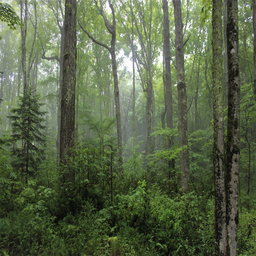

In [72]:
img_f[0]

# Custom CNN Model with Image Manipulations
## *This a stretch goal, and it's relatively difficult*

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 

In [ ]:
# State Code for Image Manipulation Here

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language